In [ ]:
!pip install segmentation_models_pytorch
!pip install torchmetrics
!pip install thop

In [ ]:
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import SegformerForSemanticSegmentation

from tqdm.notebook import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
zip_depth_ir_pm_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Dataset/SLP_Dataset_RGB_PM/Depth_IR_PM.zip'
unzip_depth_ir_pm_path = '/content/Depth_IR_PM'

os.makedirs(unzip_depth_ir_pm_path, exist_ok=True)
with zipfile.ZipFile(zip_depth_ir_pm_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_depth_ir_pm_path)

# **Dataset**

In [ ]:
class IR_PM_Dataset(Dataset):
    def __init__(self, ir_folder, pm_folder, transform):
        """
        적외선(IR) 이미지와 압력맵(PM) 이미지를 불러와서 변환하는 데이터셋 클래스입니다.
        """
        self.ir_folder = ir_folder
        self.pm_folder = pm_folder

        self.ir_images = sorted(os.listdir(self.ir_folder))
        self.pm_images = sorted(os.listdir(self.pm_folder))

        self.transform = transform

    def __len__(self):
        return len(self.pm_images)

    def __getitem__(self, idx):
        """
        적외선 이미지와 압력맵 이미지를 불러와서 정규화 및 스케일링을 진행하고 반환합니다.
        """
        # ir image
        ir_path = os.path.join(self.ir_folder, self.ir_images[idx])
        ir_img = Image.open(ir_path).convert('RGB')
        ir_img = self.normalize_scale(ir_img) # 정규화 및 스케일링

        # Pressure map
        pm_path = os.path.join(self.pm_folder, self.pm_images[idx])
        pm_img = Image.open(pm_path)
        pm_img = self.normalize_scale(pm_img) # 정규화 및 스케일링

        ir_img, pm_img = self.transform(ir_img), self.transform(pm_img)
        return ir_img, pm_img

    def normalize_scale(self, img):
        """
        적외선 이미지에서는 사람과 배경 간의 밝기 차이가 나타날 수 있도록 밝기 조정을 수행합니다.
        또한, 압력맵 이미지에서도 배경(압력이 없는 곳)과 사람(압력이 있는 곳) 간의 압력 차이가 명확히 나타날 수 있도록 밝기 조정을 수행합니다.
        """
        img = np.array(img)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8) # [0, 1] 범위로 정규화

        # 압력맵 이미지
        if len(img.shape) == 2:
            img = np.power(img, 0.5)

        # 적외선 이미지
        else:
            img = np.power(img, 0.75)

        # 이미지 픽셀 값을 0~255 사이로 클리핑 후, 정수형으로 변환
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        return img

In [ ]:
ir_path = '/content/Depth_IR_PM/IR_png'
pm_path = '/content/Depth_IR_PM/PM_png'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((512, 512))])
target_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])
dataset = IR_PM_Dataset(ir_path, pm_path, transform, target_transform)

In [ ]:
"""
훈련 데이터 크기: 전체 데이터셋의 80%
검증 데이터 크기: 전체 데이터셋의 10%
테스트 데이터 크기: 전체 데이터셋의 10%
"""

data_size = len(dataset)
train_size = int(data_size * 0.8)
val_size = int(data_size * 0.1)
test_size = data_size - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, val_size + train_size))
test_indices = list(range(val_size + train_size, data_size))

In [ ]:
print('Train samples:', train_size)
print('Val samples:', val_size)
print('Test samples:', test_size)

Train samples: 10800
Val samples: 1350
Test samples: 1350


In [ ]:
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
"""
훈련 데이터가 약 1만장이므로, 배치 크기는 32로 설정
"""

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Infrared image shape: torch.Size([3, 512, 512])
Pressure map shape: torch.Size([1, 128, 128])


Text(0.5, 1.0, 'Pressure Map (Ground Truth)')

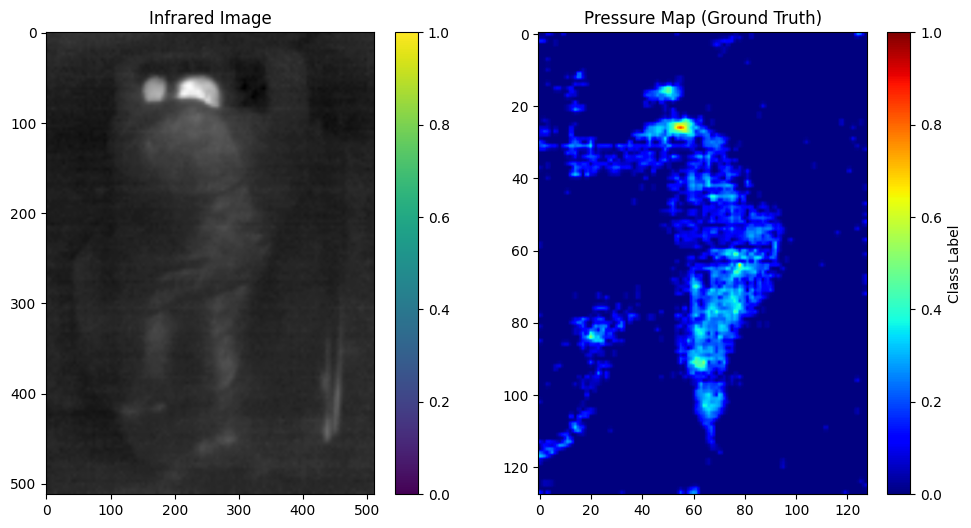

In [ ]:
    ir_sample, pm_sample = next(iter(train_loader))

    ir_sample = ir_sample[0]
    pm_sample = pm_sample[0]

    print('Infrared image shape:', ir_sample.shape)
    print('Pressure map shape:', pm_sample.shape)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(ir_sample.permute(1, 2, 0), cmap='viridis', vmin=0, vmax=1, aspect='auto')
    plt.colorbar()
    plt.title('Infrared Image')

    plt.subplot(1, 3, 2)
    plt.imshow(pm_sample.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Ground Truth)')

# **Model**

In [ ]:
class SegformerForRegression(nn.Module):
    """
    Segformer 모델을 기반으로 압력을 회귀 예측하는 모델.
    Semantic Segmentation을 위한 Segformer 모델을 로드하고,
    최종 출력 레이어를 회귀용 Conv2d 레이어로 교체.
    """
    def __init__(self, model_name: str, num_outputs: int = 1):
        super(SegformerForRegression, self).__init__()
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(model_name)

        self.segformer.decode_head.classifier = nn.Conv2d(
            in_channels=self.segformer.config.decoder_hidden_size,
            out_channels=num_outputs,
            kernel_size=1
        )

        self.segformer.auxiliary_heads = None

    def forward(self, x):
        outputs = self.segformer(x)
        logits = outputs.logits
        return logits

In [ ]:
model = SegformerForRegression(model_name="nvidia/segformer-b0-finetuned-ade-512-512")

In [ ]:
print(model)

SegformerForRegression(
  (segformer): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       

In [ ]:
# 모델의 전체 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 계산 (requires_grad=True인 파라미터들만 계산)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 3714401
Trainable parameters: 3714401


In [ ]:
from thop import profile

input_data = torch.randn(1, 3, 192, 96)
flops, params = profile(model, inputs=(input_data, ))

print(f"FLOPs: {flops / 1e9:.2f} G-Ops")
print(f"Parameters: {params / 1e6:.2f} M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
FLOPs: 0.48 G-Ops
Parameters: 3.71 M


In [ ]:
model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# RMSE (Root Mean Squared Error) 계산 함수
def RMSE(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true))

In [ ]:
def train(model, data_loader, criterion, optimizer):
    # SSIM 지표 객체 생성 (데이터 범위 1.0 설정)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    model.train()
    train_loss = 0.0
    train_rmse = 0.0
    train_ssim = 0.0

    for inputs, labels in tqdm(data_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        rmse = RMSE(outputs, labels)
        train_rmse += rmse.item()

        ssim_score = ssim_metric(outputs, labels)
        train_ssim += ssim_score.item()

    train_loss /= len(data_loader)
    train_rmse /= len(data_loader)
    train_ssim /= len(data_loader)

    return train_loss, train_rmse, train_ssim

In [ ]:
def evaluate(model, data_loader, criterion):
    # SSIM 지표 객체 생성 (데이터 범위 1.0 설정)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    model.eval()
    eval_loss = 0.0
    eval_rmse = 0.0
    eval_ssim = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item()

            rmse = RMSE(outputs, labels)
            eval_rmse += rmse.item()

            ssim_score = ssim_metric(outputs, labels)
            eval_ssim += ssim_score.item()

    eval_loss /= len(data_loader)
    eval_rmse /= len(data_loader)
    eval_ssim /= len(data_loader)

    return eval_loss, eval_rmse, eval_ssim

In [ ]:
num_epochs = 50
train_results = {'Loss': [], 'RMSE': [], 'SSIM': []}
val_results = {'Loss': [], 'RMSE': [], 'SSIM': []}

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_rmse, train_ssim = train(model, train_loader, criterion, optimizer)
    val_loss, val_rmse, val_ssim = evaluate(model, val_loader, criterion)

    end_time = time.time()

    train_results['Loss'].append(train_loss)
    val_results['Loss'].append(val_loss)

    train_results['RMSE'].append(train_rmse)
    val_results['RMSE'].append(val_rmse)

    train_results['SSIM'].append(train_ssim)
    val_results['SSIM'].append(val_ssim)

    print(f"[Epoch {epoch + 1}/{num_epochs}, {int(end_time - start_time)}s]")
    print(f"Training Loss: {train_loss:.6f} | RMSE: {train_rmse:.4f} | SSIM: {train_ssim:.4f}")
    print(f"Validation Loss: {val_loss:.6f} | RMSE: {val_rmse:.4f} | SSIM: {val_ssim:.4f}")
    print("=" * 60)
    print()

Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 1/50, 522s]
Training Loss: 0.017770 | RMSE: 0.1228 | SSIM: 0.0521
Validation Loss: 0.004889 | RMSE: 0.0699 | SSIM: 0.4450



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 2/50, 531s]
Training Loss: 0.006696 | RMSE: 0.0816 | SSIM: 0.1644
Validation Loss: 0.004718 | RMSE: 0.0687 | SSIM: 0.4401



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 3/50, 532s]
Training Loss: 0.005336 | RMSE: 0.0730 | SSIM: 0.3146
Validation Loss: 0.004539 | RMSE: 0.0673 | SSIM: 0.4390



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 4/50, 531s]
Training Loss: 0.004870 | RMSE: 0.0697 | SSIM: 0.4225
Validation Loss: 0.004548 | RMSE: 0.0674 | SSIM: 0.4712



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 5/50, 532s]
Training Loss: 0.004633 | RMSE: 0.0680 | SSIM: 0.4668
Validation Loss: 0.004384 | RMSE: 0.0662 | SSIM: 0.5609



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 6/50, 532s]
Training Loss: 0.004462 | RMSE: 0.0668 | SSIM: 0.4863
Validation Loss: 0.004242 | RMSE: 0.0651 | SSIM: 0.5673



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 7/50, 532s]
Training Loss: 0.004341 | RMSE: 0.0658 | SSIM: 0.4851
Validation Loss: 0.004196 | RMSE: 0.0648 | SSIM: 0.5439



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 8/50, 532s]
Training Loss: 0.004210 | RMSE: 0.0648 | SSIM: 0.4918
Validation Loss: 0.004096 | RMSE: 0.0640 | SSIM: 0.5646



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 9/50, 532s]
Training Loss: 0.004082 | RMSE: 0.0638 | SSIM: 0.5043
Validation Loss: 0.003992 | RMSE: 0.0631 | SSIM: 0.5689



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 10/50, 532s]
Training Loss: 0.003981 | RMSE: 0.0631 | SSIM: 0.4909
Validation Loss: 0.004017 | RMSE: 0.0634 | SSIM: 0.5825



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 11/50, 533s]
Training Loss: 0.003861 | RMSE: 0.0621 | SSIM: 0.5059
Validation Loss: 0.003948 | RMSE: 0.0628 | SSIM: 0.5738



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 12/50, 532s]
Training Loss: 0.003740 | RMSE: 0.0611 | SSIM: 0.5179
Validation Loss: 0.003886 | RMSE: 0.0623 | SSIM: 0.5203



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 13/50, 532s]
Training Loss: 0.003639 | RMSE: 0.0603 | SSIM: 0.5226
Validation Loss: 0.003807 | RMSE: 0.0617 | SSIM: 0.5915



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 14/50, 532s]
Training Loss: 0.003521 | RMSE: 0.0593 | SSIM: 0.5329
Validation Loss: 0.003847 | RMSE: 0.0620 | SSIM: 0.5800



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 15/50, 532s]
Training Loss: 0.003437 | RMSE: 0.0586 | SSIM: 0.5256
Validation Loss: 0.003722 | RMSE: 0.0610 | SSIM: 0.5746



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 16/50, 533s]
Training Loss: 0.003339 | RMSE: 0.0578 | SSIM: 0.5406
Validation Loss: 0.003730 | RMSE: 0.0610 | SSIM: 0.5814



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 17/50, 533s]
Training Loss: 0.003247 | RMSE: 0.0570 | SSIM: 0.5467
Validation Loss: 0.003664 | RMSE: 0.0605 | SSIM: 0.5847



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 18/50, 533s]
Training Loss: 0.003179 | RMSE: 0.0564 | SSIM: 0.5575
Validation Loss: 0.003937 | RMSE: 0.0627 | SSIM: 0.5855



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 19/50, 533s]
Training Loss: 0.003107 | RMSE: 0.0557 | SSIM: 0.5607
Validation Loss: 0.003688 | RMSE: 0.0607 | SSIM: 0.6255



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 20/50, 533s]
Training Loss: 0.003055 | RMSE: 0.0552 | SSIM: 0.5616
Validation Loss: 0.003483 | RMSE: 0.0590 | SSIM: 0.6390



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 21/50, 533s]
Training Loss: 0.002970 | RMSE: 0.0545 | SSIM: 0.5879
Validation Loss: 0.003635 | RMSE: 0.0603 | SSIM: 0.4529



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 22/50, 533s]
Training Loss: 0.002912 | RMSE: 0.0539 | SSIM: 0.5809
Validation Loss: 0.003536 | RMSE: 0.0594 | SSIM: 0.6104



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 23/50, 533s]
Training Loss: 0.002862 | RMSE: 0.0535 | SSIM: 0.5881
Validation Loss: 0.003503 | RMSE: 0.0592 | SSIM: 0.6076



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 24/50, 533s]
Training Loss: 0.002822 | RMSE: 0.0531 | SSIM: 0.5907
Validation Loss: 0.003453 | RMSE: 0.0587 | SSIM: 0.6281



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 25/50, 533s]
Training Loss: 0.002768 | RMSE: 0.0526 | SSIM: 0.6019
Validation Loss: 0.003579 | RMSE: 0.0598 | SSIM: 0.6504



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 26/50, 534s]
Training Loss: 0.002704 | RMSE: 0.0520 | SSIM: 0.6258
Validation Loss: 0.003552 | RMSE: 0.0596 | SSIM: 0.6431



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 27/50, 533s]
Training Loss: 0.002685 | RMSE: 0.0518 | SSIM: 0.6189
Validation Loss: 0.003425 | RMSE: 0.0585 | SSIM: 0.5820



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 28/50, 533s]
Training Loss: 0.002638 | RMSE: 0.0513 | SSIM: 0.6199
Validation Loss: 0.003532 | RMSE: 0.0594 | SSIM: 0.6655



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 29/50, 533s]
Training Loss: 0.002628 | RMSE: 0.0512 | SSIM: 0.6180
Validation Loss: 0.003495 | RMSE: 0.0591 | SSIM: 0.6430



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 30/50, 533s]
Training Loss: 0.002576 | RMSE: 0.0507 | SSIM: 0.6316
Validation Loss: 0.003446 | RMSE: 0.0587 | SSIM: 0.6382



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 31/50, 533s]
Training Loss: 0.002534 | RMSE: 0.0503 | SSIM: 0.6477
Validation Loss: 0.003600 | RMSE: 0.0600 | SSIM: 0.6484



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 32/50, 533s]
Training Loss: 0.002496 | RMSE: 0.0499 | SSIM: 0.6570
Validation Loss: 0.003541 | RMSE: 0.0595 | SSIM: 0.6625



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 33/50, 533s]
Training Loss: 0.002480 | RMSE: 0.0498 | SSIM: 0.6609
Validation Loss: 0.003456 | RMSE: 0.0588 | SSIM: 0.6669



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 34/50, 533s]
Training Loss: 0.002416 | RMSE: 0.0491 | SSIM: 0.6660
Validation Loss: 0.003500 | RMSE: 0.0591 | SSIM: 0.6604



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 35/50, 533s]
Training Loss: 0.002385 | RMSE: 0.0488 | SSIM: 0.6698
Validation Loss: 0.003638 | RMSE: 0.0603 | SSIM: 0.6065



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 36/50, 533s]
Training Loss: 0.002335 | RMSE: 0.0483 | SSIM: 0.6761
Validation Loss: 0.003468 | RMSE: 0.0588 | SSIM: 0.6616



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 37/50, 533s]
Training Loss: 0.002330 | RMSE: 0.0482 | SSIM: 0.6752
Validation Loss: 0.003443 | RMSE: 0.0586 | SSIM: 0.6331



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 38/50, 533s]
Training Loss: 0.002294 | RMSE: 0.0479 | SSIM: 0.6807
Validation Loss: 0.003445 | RMSE: 0.0587 | SSIM: 0.6583



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 39/50, 533s]
Training Loss: 0.002263 | RMSE: 0.0475 | SSIM: 0.6843
Validation Loss: 0.003362 | RMSE: 0.0580 | SSIM: 0.6652



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 40/50, 533s]
Training Loss: 0.002242 | RMSE: 0.0473 | SSIM: 0.6862
Validation Loss: 0.003389 | RMSE: 0.0582 | SSIM: 0.6741



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 41/50, 533s]
Training Loss: 0.002202 | RMSE: 0.0469 | SSIM: 0.6891
Validation Loss: 0.003424 | RMSE: 0.0585 | SSIM: 0.6733



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 42/50, 533s]
Training Loss: 0.002173 | RMSE: 0.0466 | SSIM: 0.6929
Validation Loss: 0.003416 | RMSE: 0.0584 | SSIM: 0.6696



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 43/50, 533s]
Training Loss: 0.002164 | RMSE: 0.0465 | SSIM: 0.6933
Validation Loss: 0.003414 | RMSE: 0.0584 | SSIM: 0.6679



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 44/50, 533s]
Training Loss: 0.002133 | RMSE: 0.0462 | SSIM: 0.6970
Validation Loss: 0.003419 | RMSE: 0.0584 | SSIM: 0.6645



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 45/50, 533s]
Training Loss: 0.002102 | RMSE: 0.0458 | SSIM: 0.6977
Validation Loss: 0.003447 | RMSE: 0.0587 | SSIM: 0.6522



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 46/50, 533s]
Training Loss: 0.002092 | RMSE: 0.0457 | SSIM: 0.7002
Validation Loss: 0.003549 | RMSE: 0.0595 | SSIM: 0.6679



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 47/50, 533s]
Training Loss: 0.002067 | RMSE: 0.0454 | SSIM: 0.7024
Validation Loss: 0.003701 | RMSE: 0.0608 | SSIM: 0.6050



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 48/50, 533s]
Training Loss: 0.002042 | RMSE: 0.0452 | SSIM: 0.7045
Validation Loss: 0.003420 | RMSE: 0.0585 | SSIM: 0.6722



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 49/50, 533s]
Training Loss: 0.002026 | RMSE: 0.0450 | SSIM: 0.7031
Validation Loss: 0.003492 | RMSE: 0.0591 | SSIM: 0.6586



Training:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

[Epoch 50/50, 533s]
Training Loss: 0.001999 | RMSE: 0.0447 | SSIM: 0.7094
Validation Loss: 0.003445 | RMSE: 0.0587 | SSIM: 0.6675



In [ ]:
test_loss, test_rmse, test_ssim = evaluate(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Test Loss: 0.003926
Test RMSE: 0.0625
Test SSIM: 0.6437


## **Result - Metrics (Loss, RMSE, SSIM)**

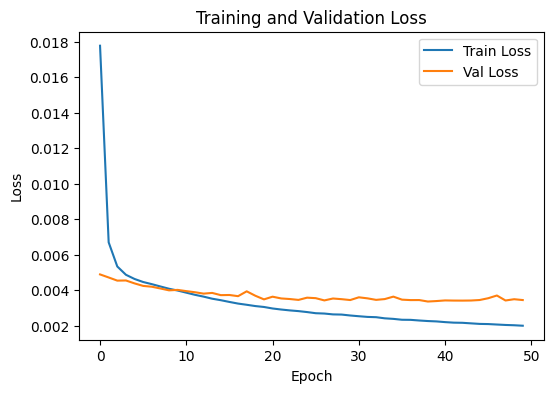

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['Loss'], label='Train Loss')
plt.plot(val_results['Loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

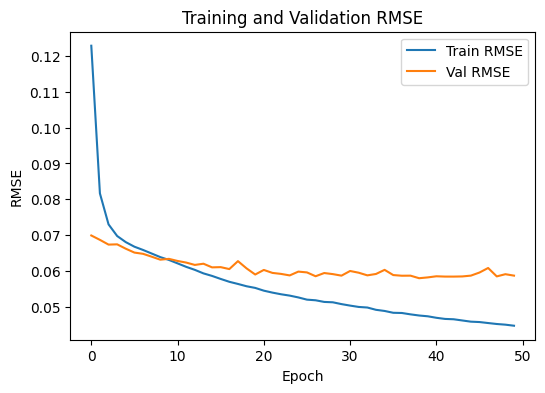

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['RMSE'], label='Train RMSE')
plt.plot(val_results['RMSE'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

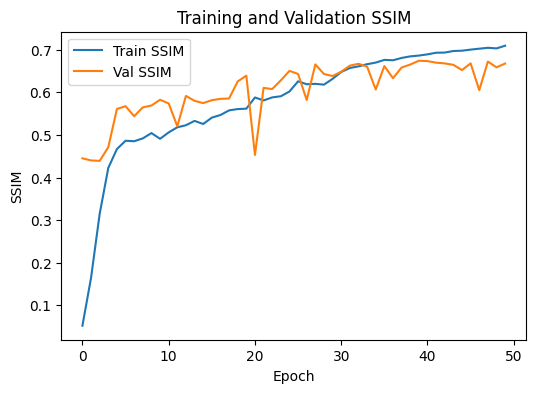

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_results['SSIM'], label='Train SSIM')
plt.plot(val_results['SSIM'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Training and Validation SSIM')
plt.legend()
plt.show()

# **Results - Prediction image**

In [ ]:
# 모델 예측 결과를 시각화하는 함수
def visualize_result(model, data_loader, is_data = 'Train'):
    # 데이터 로더의 첫번째 배치의 첫번째 데이터를 사용
    ir, pm_gt = next(iter(data_loader))
    ir = ir[0]
    pm_gt = pm_gt[0]

    with torch.no_grad():
        model.eval()

        ir = ir.unsqueeze(0).to(device)
        pm_pred = model(ir)
        pm_pred = pm_pred.cpu()

    # SSIM 및 RMSE 계산
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    rmse = RMSE(pm_pred, pm_gt.unsqueeze(0)).item()
    ssim = ssim_metric(pm_pred, pm_gt.unsqueeze(0)).item()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(ir.squeeze(0).permute(1, 2, 0).cpu(), aspect='auto')
    plt.colorbar()

    if is_data == 'Train':
        plt.title('Infrared Image (Train)')
    elif is_data == 'Val':
        plt.title('Infrared Image (Validation)')
    elif is_data == 'Test':
        plt.title('Infrared Image (Test)')

    plt.subplot(1, 3, 2)
    plt.imshow(pm_gt.squeeze(0), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Ground Truth)')

    plt.subplot(1, 3, 3)
    plt.imshow(pm_pred.squeeze().numpy(), cmap='jet', vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title(f'Pressure Map (Prediction)\nRMSE: {rmse:.4f}, SSIM: {ssim:.4f}')

    plt.tight_layout()
    plt.show()

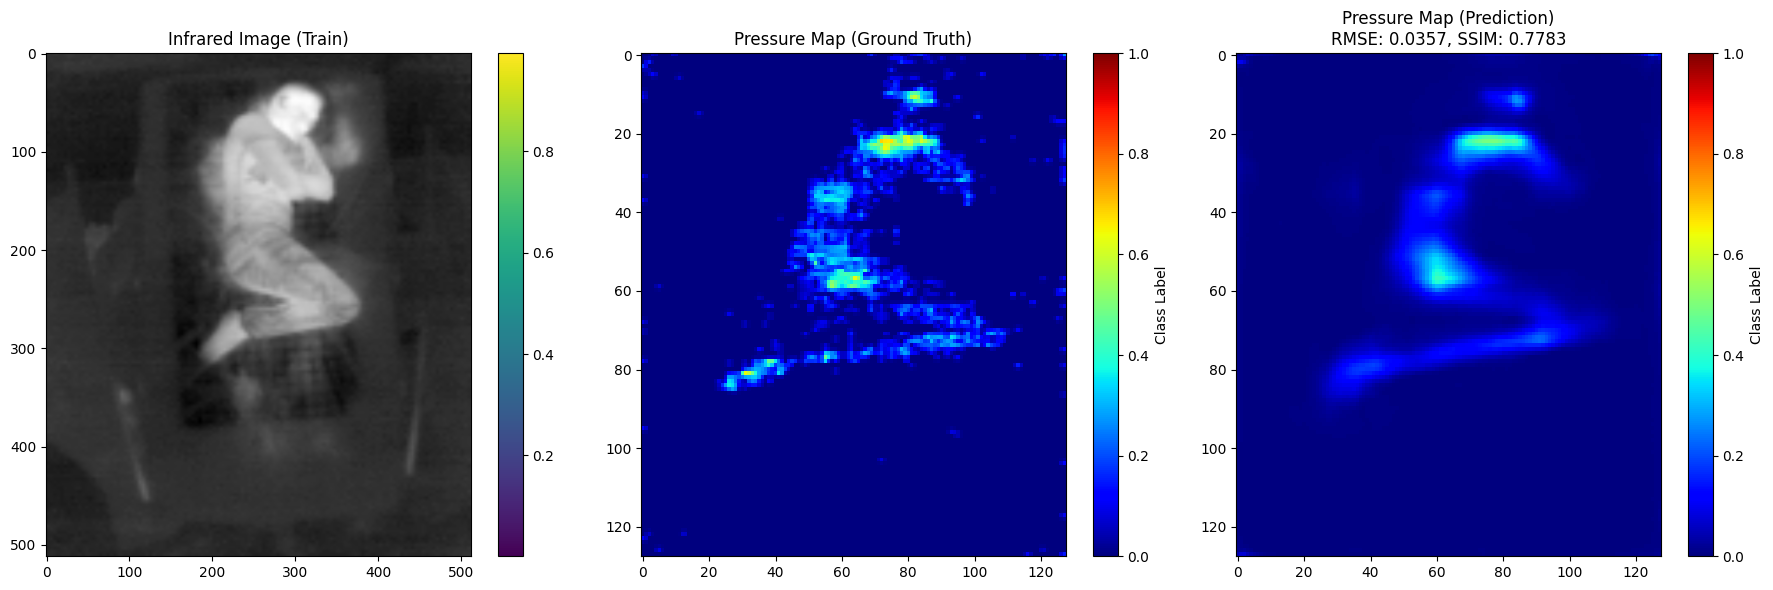

In [ ]:
# 훈련 데이터에 대한 결과 시각화
visualize_result(model, train_loader, 'Train')

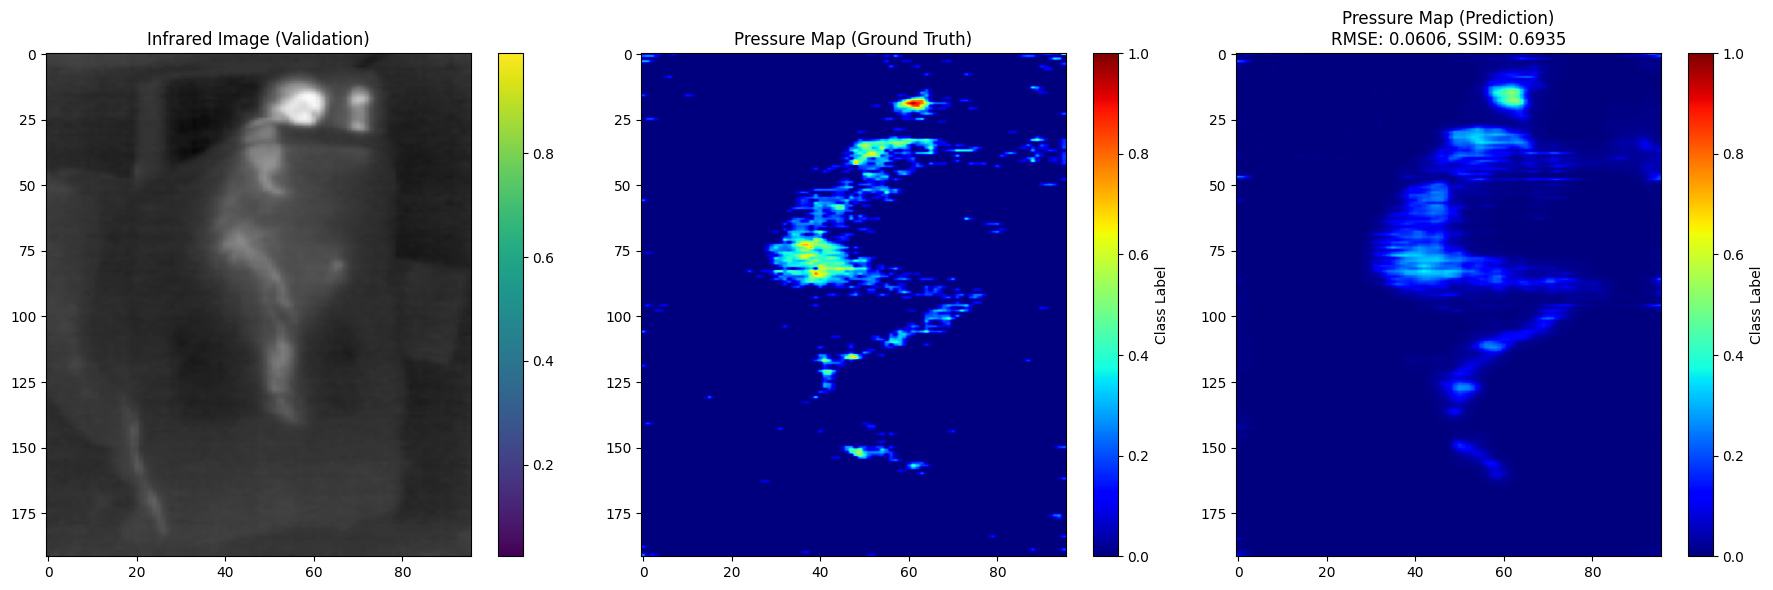

In [ ]:
# 검증 데이터에 대한 결과 시각화
visualize_result(model, val_loader, 'Val')

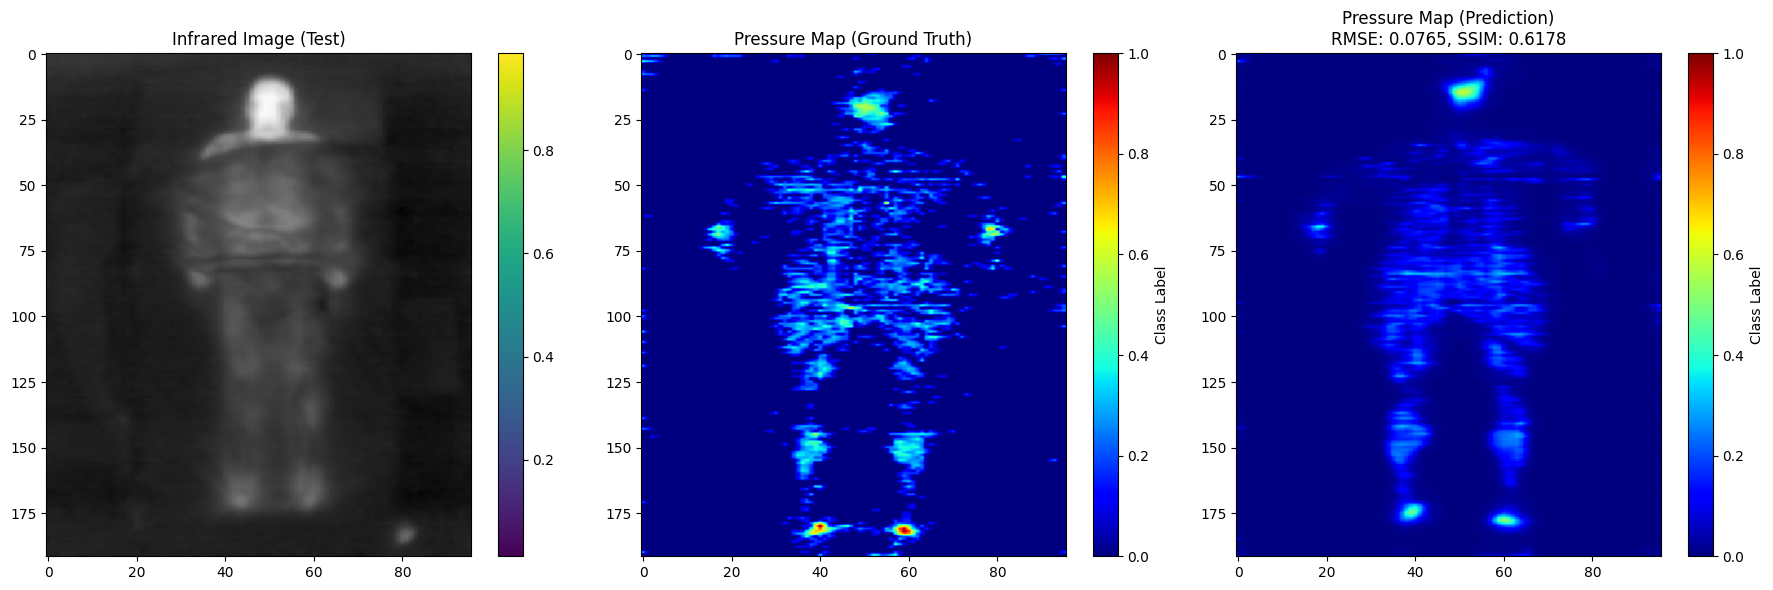

In [ ]:
# 테스트 데이터에 대한 결과 시각화
visualize_result(model, test_loader, 'Test')

In [ ]:
save_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Code/model_save/IR_PM_save (색 대비, 최종본)'
checkpoint_path = os.path.join(save_path, 'Segformer_E50.pth')

if not os.path.exists(checkpoint_path):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
    print('model save 완료.')
else:
    print('model save 이미 완료.')

model save 완료.
